# Load Data

In [ ]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 5.1 MB/s 
     |████████████████████████████████| 132 kB 55.3 MB/s 
     |████████████████████████████████| 10.2 MB 28.3 MB/s 
     |████████████████████████████████| 79 kB 5.9 MB/s 
     |████████████████████████████████| 140 kB 29.2 MB/s 
     |████████████████████████████████| 127 kB 15.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir
from utils import (TAG2IDX, IDX2TAG, DATA_DIR, WSJ_DIR, MODEL_DIR, 
                   INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR)
from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train, eval

from analysis import save_sns_fig, save_plotly_fig, analysis_output

from create_pseudo_data import gen_pseudo_data

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)


Mounted at /content/drive
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


100%|██████████| 213450/213450 [00:00<00:00, 3793599.00B/s]


In [ ]:
model = Net(vocab_size=len(TAG2IDX))
model.to(DEVICE)
model = nn.DataParallel(model)

100%|██████████| 404400730/404400730 [00:10<00:00, 39678602.71B/s]


In [ ]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
model_file = os.path.join(MODEL_DIR, "base_model.pt")
model.load_state_dict(torch.load(model_file))
(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value, 
 micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value,
 macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value) = eval(model, test_iter, save_output=False)

print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)
print(micro_wsj_precision_value, micro_wsj_recall_value, micro_wsj_f1_value, micro_wsj_acc_value)
print(macro_wsj_precision_value, macro_wsj_recall_value, macro_wsj_f1_value, macro_wsj_acc_value)


tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)
tensor(0.9743) tensor(0.9743) tensor(0.9743) tensor(0.9743)
tensor(0.8648) tensor(0.8656) tensor(0.8558) tensor(0.8656)


# Self Training

In [ ]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [ ]:
domain = "newsgroups"
domain_dir = os.path.join(DATA_DIR, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [ ]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 1196
The number of tags 49
The number of samples: 1195
The number of tags 49
after filter tag 1190
after filter tag 1180


In [ ]:
# method_name: Online_fixed_self_learning, Online_nonfixed_self_learning, 
#               Scratch_fixed_self_learning, Scratch_nonfixed_self_learning,
#               Online_token_self_learning, Scratch_token_self_learning

(sub_model_dir, sub_metrics_dir, sub_result_dir, 
 sub_plots_tags_dir, sub_int_res_dir) = create_sub_dir(domain, method_name="Online_nonfixed_self_learning")

Create /content/drive/.shortcut-targets-by-id/14c0k_vTOqyJvw3jILduI00xS9-yQkgb8/Capstone/model/Online_nonfixed_self_learning/newsgroups
Create /content/drive/.shortcut-targets-by-id/14c0k_vTOqyJvw3jILduI00xS9-yQkgb8/Capstone/metrics/Online_nonfixed_self_learning/newsgroups
Create /content/drive/.shortcut-targets-by-id/14c0k_vTOqyJvw3jILduI00xS9-yQkgb8/Capstone/result/Online_nonfixed_self_learning/newsgroups
Create /content/drive/.shortcut-targets-by-id/14c0k_vTOqyJvw3jILduI00xS9-yQkgb8/Capstone/plots_tags/Online_nonfixed_self_learning/newsgroups
Create /content/drive/.shortcut-targets-by-id/14c0k_vTOqyJvw3jILduI00xS9-yQkgb8/Capstone/intermediate_result/Online_nonfixed_self_learning/newsgroups


In [ ]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

micro_domain_precision_value_lst = []
micro_domain_recall_value_lst = []
micro_domain_f1_value_lst = []
micro_domain_acc_value_lst = []

macro_domain_precision_value_lst = []
macro_domain_recall_value_lst = []
macro_domain_f1_value_lst = []
macro_domain_acc_value_lst = []

In [ ]:
loop_i = 0
threshold = 0.02
top_percent = 0.6

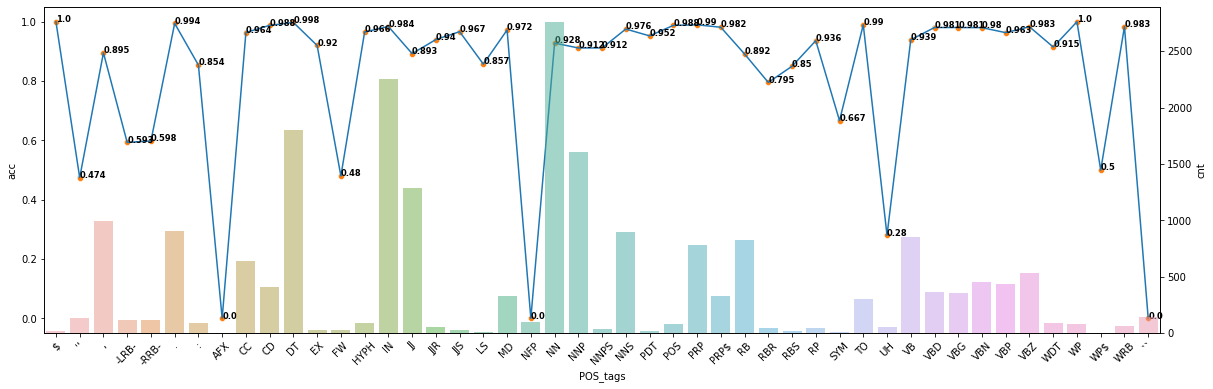

In [ ]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.txt")
(domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
 precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
 precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)

micro_domain_precision_value_lst.append(precision_value_micro)
micro_domain_recall_value_lst.append(recall_value_micro)
micro_domain_f1_value_lst.append(f1_value_micro)
micro_domain_acc_value_lst.append(acc_micro)

macro_domain_precision_value_lst.append(precision_value_macro)
macro_domain_recall_value_lst.append(recall_value_macro)
macro_domain_f1_value_lst.append(f1_value_macro)
macro_domain_acc_value_lst.append(acc_macro)


The number of sentences in top n 714
Stop condation 14

Loop 1
Difference 701


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.050345372408628464
step: 10, loss: 0.020373515784740448
step: 20, loss: 0.046116095036268234
step: 30, loss: 0.023238088935613632
step: 40, loss: 0.035038188099861145
step: 50, loss: 0.021732015535235405
step: 60, loss: 0.02712540328502655
step: 70, loss: 0.0439002588391304
step: 80, loss: 0.03643530234694481

Loop 2
Difference 297


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.0058615305460989475
step: 10, loss: 0.015507430769503117
step: 20, loss: 0.014049188233911991
step: 30, loss: 0.018738610669970512
step: 40, loss: 0.014656207524240017
step: 50, loss: 0.003743181237950921
step: 60, loss: 0.0062034460715949535
step: 70, loss: 0.029950717464089394
step: 80, loss: 0.01807694137096405

Loop 3
Difference 40


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.006305857561528683
step: 10, loss: 0.02920057624578476
step: 20, loss: 0.00710827624425292
step: 30, loss: 0.008530918508768082
step: 40, loss: 0.02287067100405693
step: 50, loss: 0.0040996260941028595
step: 60, loss: 0.002955468837171793
step: 70, loss: 0.040474243462085724
step: 80, loss: 0.0486987866461277

Loop 4
Difference 32


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.003965203184634447
step: 10, loss: 0.0569770447909832
step: 20, loss: 0.015771478414535522
step: 30, loss: 0.003412021091207862
step: 40, loss: 0.005123949609696865
step: 50, loss: 0.0019315782701596618
step: 60, loss: 0.004899398423731327
step: 70, loss: 0.004396714270114899
step: 80, loss: 0.002869343850761652

Loop 5
Difference 24


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.007378117647022009
step: 10, loss: 0.002305548405274749
step: 20, loss: 0.0023385232780128717
step: 30, loss: 0.0019237911328673363
step: 40, loss: 0.0037243030965328217
step: 50, loss: 0.002749171108007431
step: 60, loss: 0.002774434396997094
step: 70, loss: 0.01796748675405979
step: 80, loss: 0.0064852540381252766

Loop 6
Difference 18


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.0011155782267451286
step: 10, loss: 0.007848331704735756
step: 20, loss: 0.0008168856729753315
step: 30, loss: 0.004732745699584484
step: 40, loss: 0.001052005565725267
step: 50, loss: 0.0005503821885213256
step: 60, loss: 0.0004519461072050035
step: 70, loss: 0.0016665313160046935
step: 80, loss: 0.0011637944262474775

Loop 7
Difference 15


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.001436654245480895
step: 10, loss: 0.0013727095210924745
step: 20, loss: 0.0009290883899666369
step: 30, loss: 0.0009279149817302823
step: 40, loss: 0.0005962376017123461
step: 50, loss: 0.00039922643918544054
step: 60, loss: 0.00038861800567246974
step: 70, loss: 0.0007167131989262998
step: 80, loss: 0.0018540277378633618

Loop 8
Difference 17


/content/drive/MyDrive/Colab Notebooks/Capstone/create_pseudo_data.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=num_classes,


step: 0, loss: 0.0004767070640809834
step: 10, loss: 0.0020107896998524666
step: 20, loss: 0.0008909945609048009
step: 30, loss: 0.0002587249909993261
step: 40, loss: 0.00132593116723001
step: 50, loss: 0.0005688405362889171
step: 60, loss: 0.00030958859133534133
step: 70, loss: 0.0004506798286456615
step: 80, loss: 0.0005003359983675182


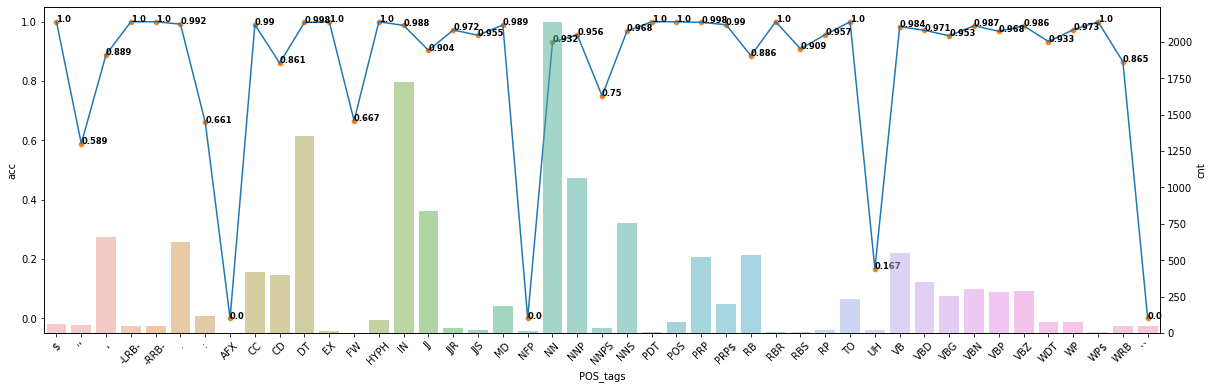

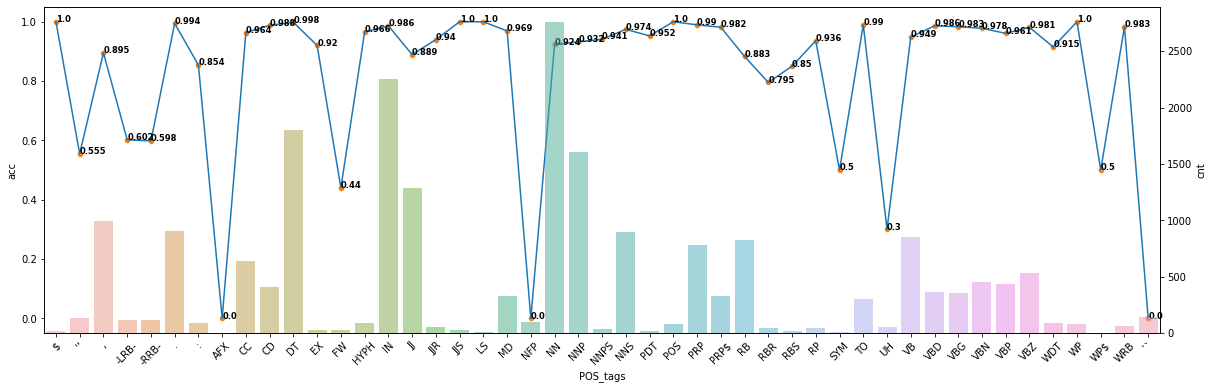

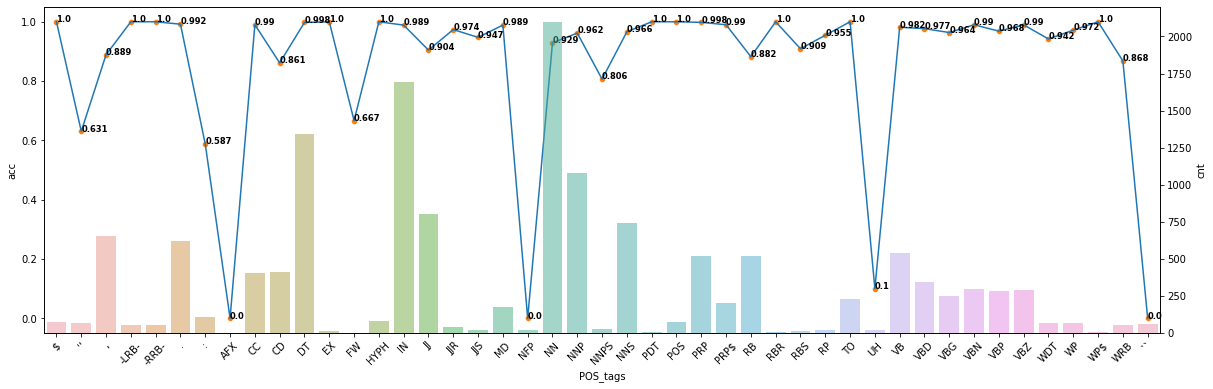

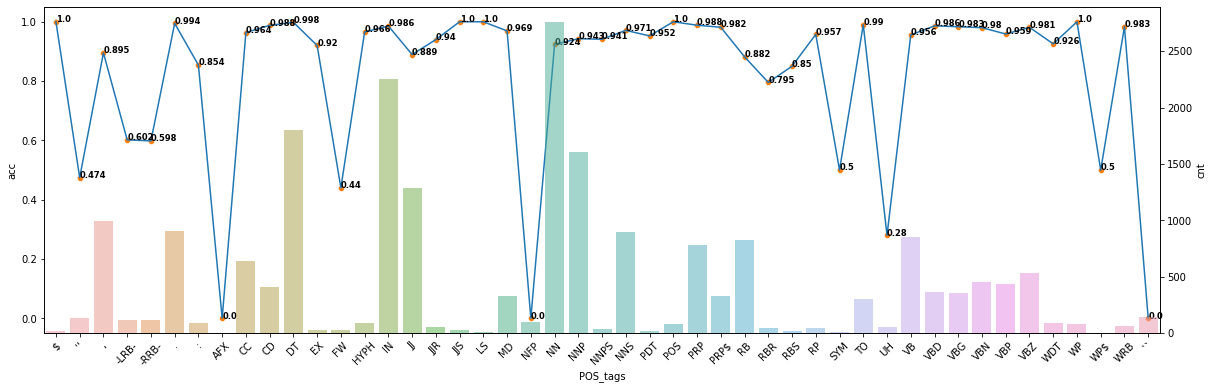

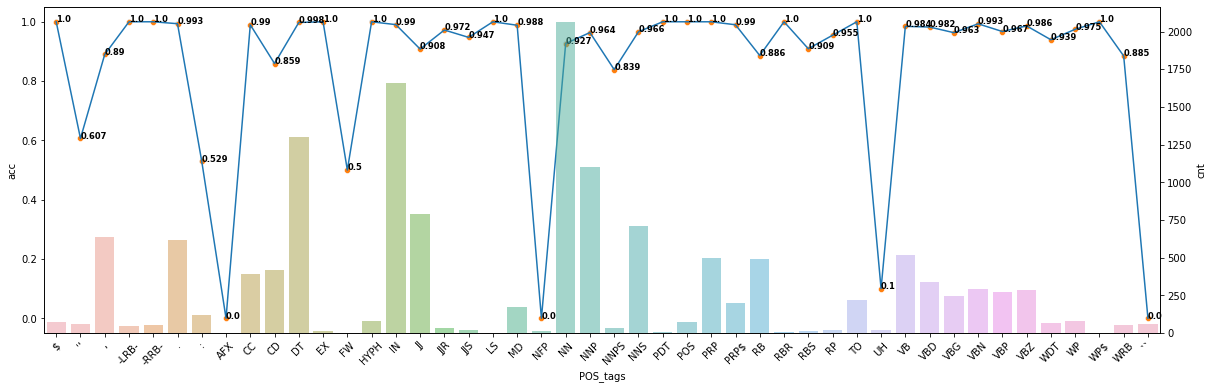

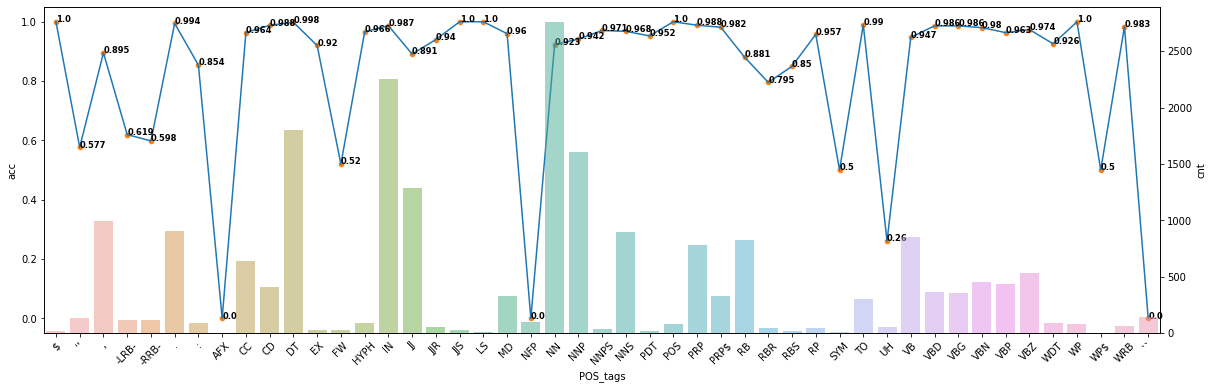

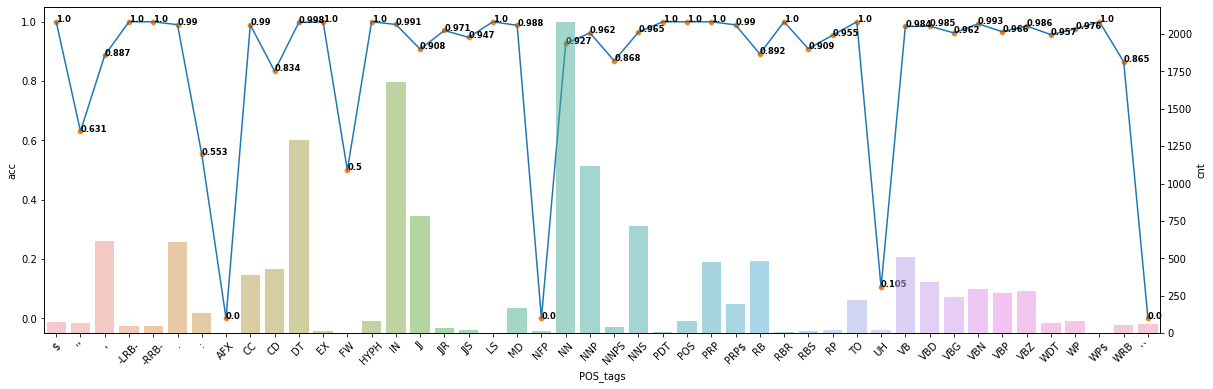

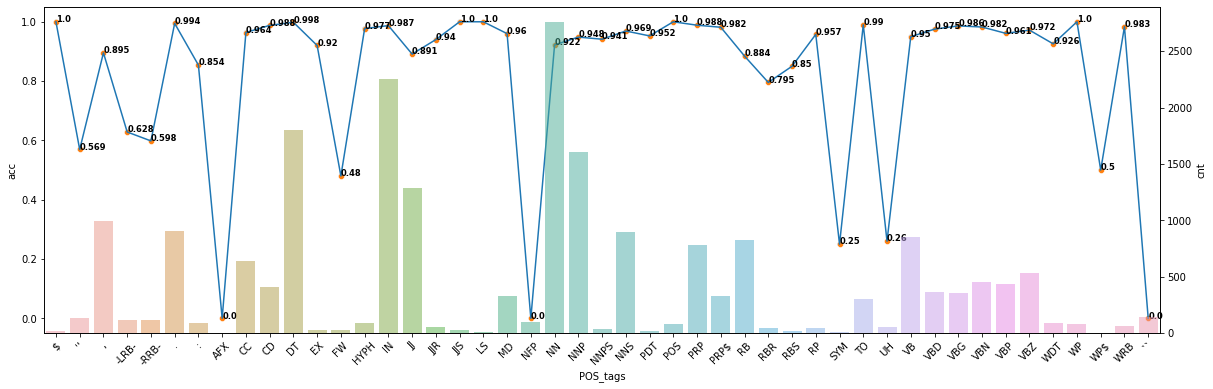

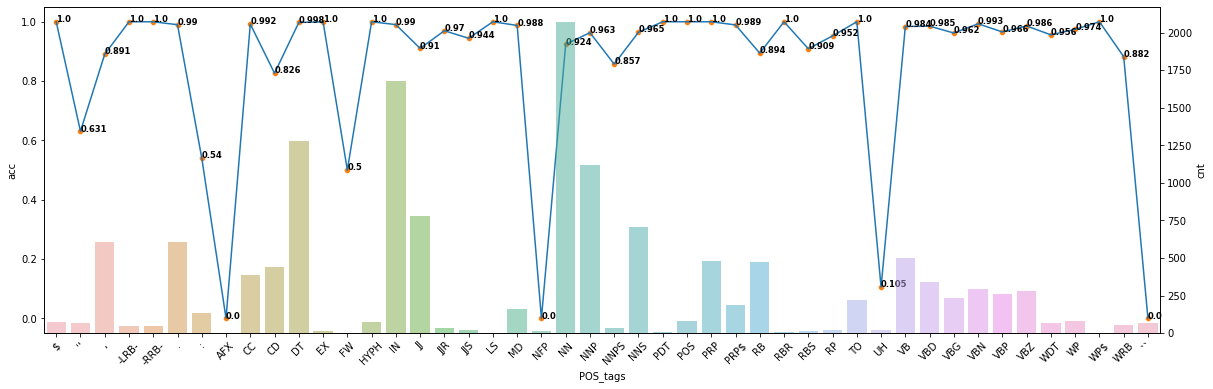

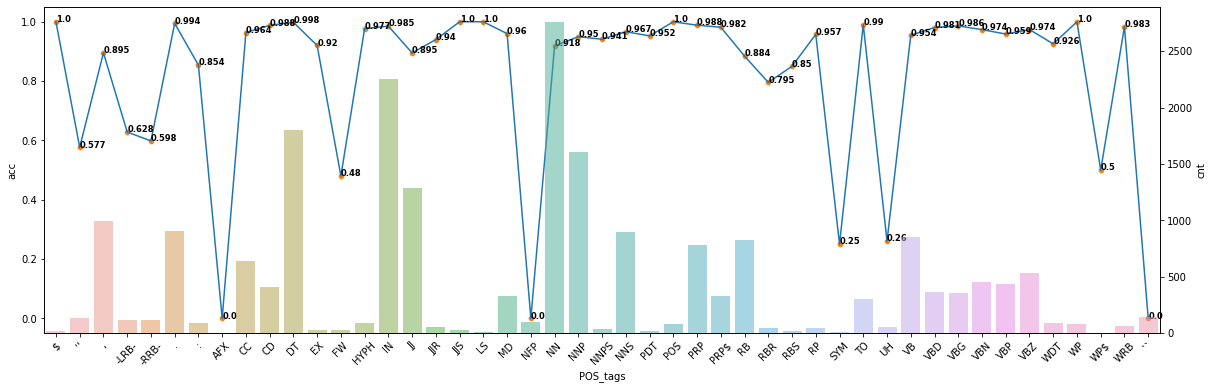

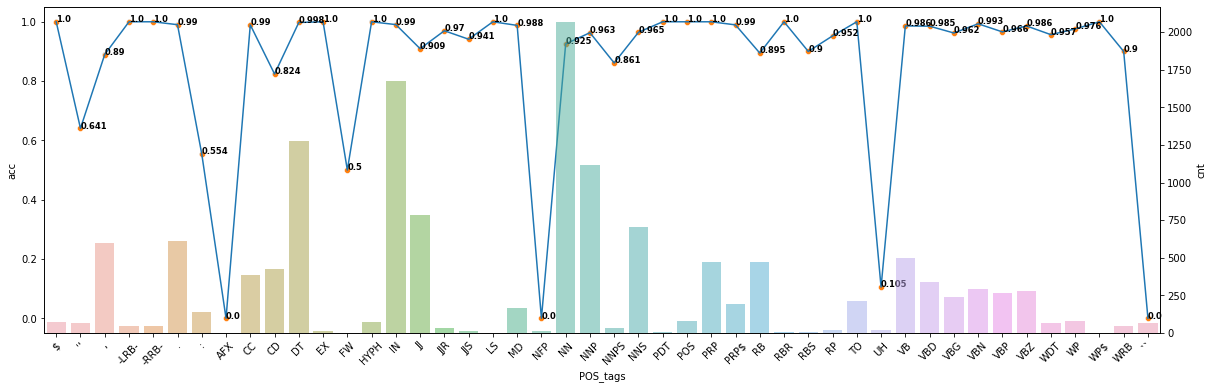

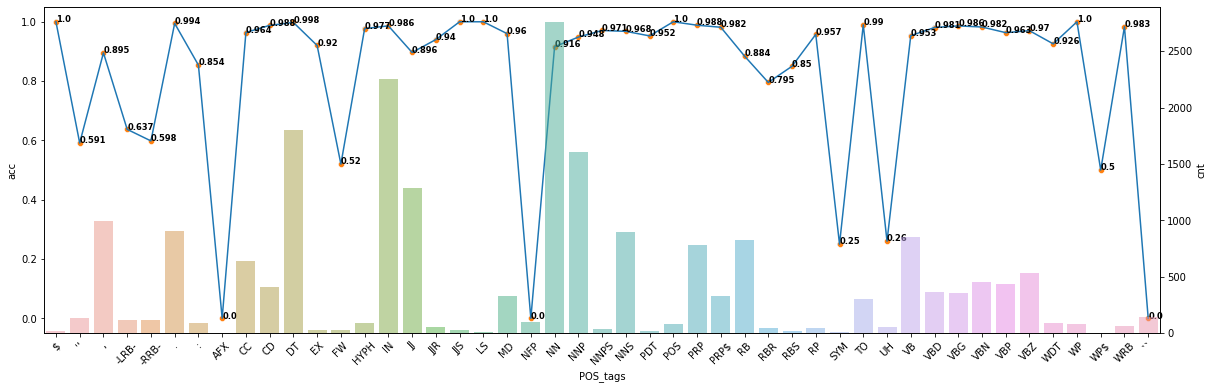

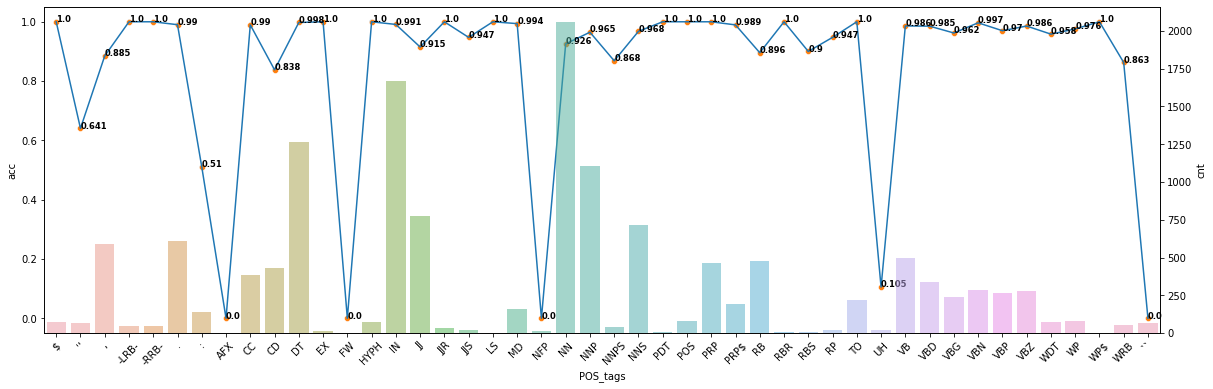

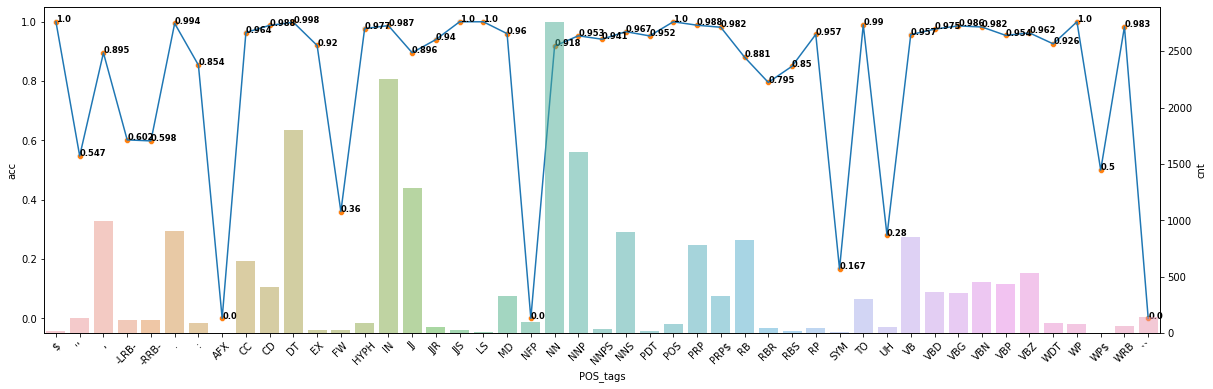

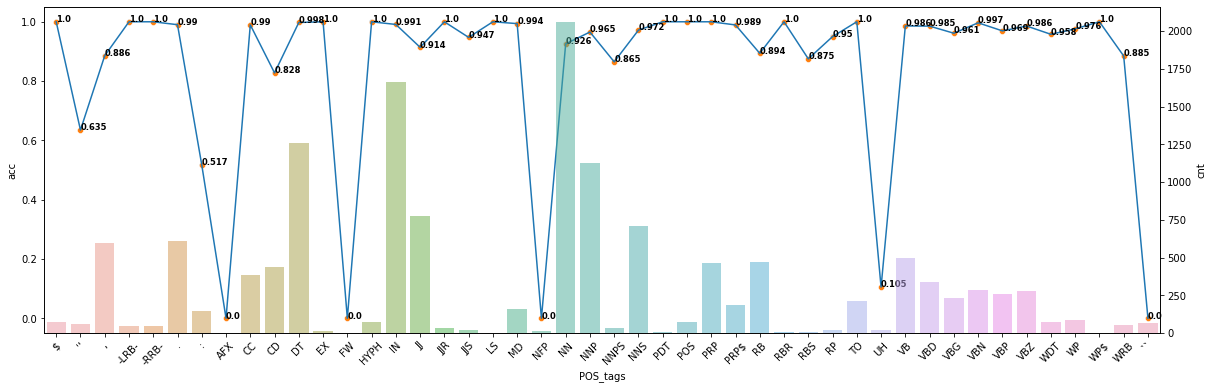

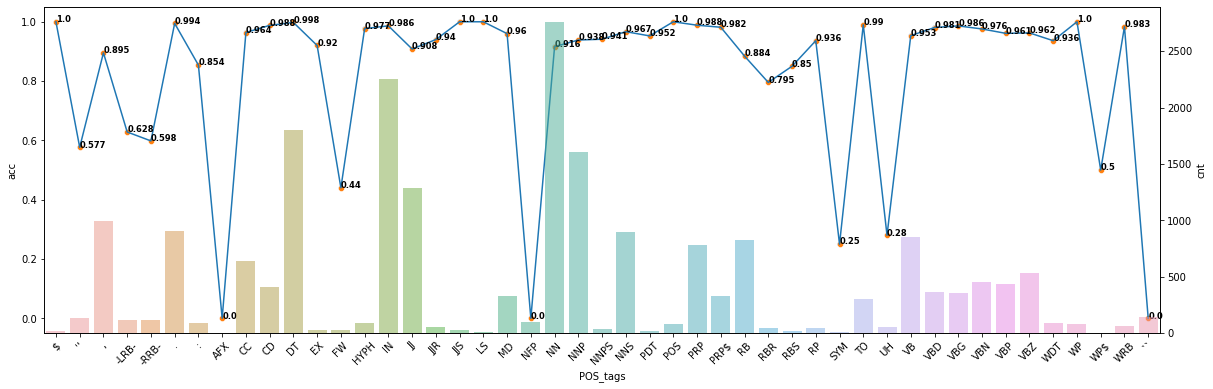

In [ ]:
acc_lst = []
prob_lst = []

topn = int(top_percent * len(domain_dev_word_lst))
print("The number of sentences in top n", topn)
print("Stop condation", int(threshold * topn))

last_top_sen = set()
top_words = domain_dev_word_lst[:topn]
new_top_sen = set([tuple(sen) for sen in top_words])

while len(new_top_sen.difference(last_top_sen)) > int(threshold * topn):
  loop_i += 1
  print("\nLoop", loop_i)
  print("Difference", len(new_top_sen.difference(last_top_sen)))

  domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

  domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=1,
                              collate_fn=pad)
  
  # Save analysis outputs for intermediate results
  int_csv_file_name = os.path.join(sub_int_res_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.csv")
  int_output_plot_name = os.path.join(sub_int_res_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.png")
  output_int_res_file = os.path.join(sub_int_res_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.txt") 
  
  (top_words, top_tags, top_pseudo_tags, top_prob, top_acc, remain_words, 
   remain_tags, remain_pseudo_tags, remain_prob, remain_acc)= gen_pseudo_data(
       model, domain_dev_iter, topn, save_output=True, output_file=output_int_res_file, 
       csvsave=True, pngsave=True, csv_file_name=int_csv_file_name, output_plot_name=int_output_plot_name)
  
  last_top_sen = new_top_sen
  new_top_sen = set([tuple(sen) for sen in top_words])

  new_train_dataset = PosDataset(top_words, top_pseudo_tags)
  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad)
  
  # domain_dev_word_lst = remain_words
  # domain_dev_tag_lst = remain_tags

  optimizer = optim.Adam(model.parameters(), lr = 0.00001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train(model, new_train_iter, optimizer, criterion)
  
  # # Save models
  # model_file = os.path.join(sub_model_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.pt")
  # torch.save(model.state_dict(), model_file)

  # Save final results
  output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.txt")
  (domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value,
   precision_value_micro, recall_value_micro, f1_value_micro, acc_micro, 
   precision_value_macro, recall_value_macro, f1_value_macro, acc_macro) = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  micro_domain_precision_value_lst.append(precision_value_micro)
  micro_domain_recall_value_lst.append(recall_value_micro)
  micro_domain_f1_value_lst.append(f1_value_micro)
  micro_domain_acc_value_lst.append(acc_micro)

  macro_domain_precision_value_lst.append(precision_value_macro)
  macro_domain_recall_value_lst.append(recall_value_macro)
  macro_domain_f1_value_lst.append(f1_value_macro)
  macro_domain_acc_value_lst.append(acc_macro)

  acc_lst.append(top_acc)
  prob_lst.append(top_prob)

  # Save analysis outputs for final results
  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-threshold{threshold}-loop{loop_i}.png")
  _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

  if loop_i == 15:
    break


In [ ]:
# print(domain_precision_value_lst)
# print(domain_recall_value_lst)
# print(domain_f1_value_lst)
# print(domain_acc_value_lst)

# print(acc_lst)
# print(prob_lst)

In [ ]:
def plot_metric(precision, recall, f1, acc):

  test_metric = pd.DataFrame({
      "Loop": list(range(len(precision))) * 4,
      "metric": ["precision"]*len(precision) + ["recall"]*len(recall) + ["f1"]*len(f1) + ["accuracy"]*len(acc),
      "value": precision + recall + f1 + acc
  })

  fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
  fig.show()
  return test_metric

In [ ]:
_ = plot_metric(domain_precision_value_lst, domain_recall_value_lst, domain_f1_value_lst, domain_acc_value_lst)

In [ ]:
_ = plot_metric(micro_domain_precision_value_lst, micro_domain_recall_value_lst, micro_domain_f1_value_lst, micro_domain_acc_value_lst)

In [ ]:
_ = plot_metric(macro_domain_precision_value_lst, macro_domain_recall_value_lst, macro_domain_f1_value_lst, macro_domain_acc_value_lst)